# Visual SLAM
A short illustration of Visual SLAM (Simultaneous Localization and Mapping) using visual features.

In [1]:
!ls

3-D_1.jpg         3-D_5.jpg         3-D_8.jpg         data
3-D_10.jpg        3-D_6.jpg         3-D_9.jpg         output
3-D_2.jpg         3-D_7.jpg         Visual_SLAM.ipynb


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
from mpl_toolkits.mplot3d import Axes3D

In [3]:
%matplotlib inline

def plot_image(title, image, cmap=None):
    plt.figure(figsize=(20,20))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.show()

In [4]:
MIN_MATCH_COUNT = 10


# Load Different Image Pairs
img_pairs = [("0000000148.png","0000000149.png")]
counter = 0

# Replace K with KITTI Intrinsic Matrix
K = np.array([[718.86, 0., 607.19],
              [0., 718.86, 185.21],
              [0.,   0.,   1.]])

In [5]:
OUTPUT_DIR = "output"
IMAGE_DIR = "data/images/image_pair"
!ls data/images/image_pair

0000000148.png 0000000149.png


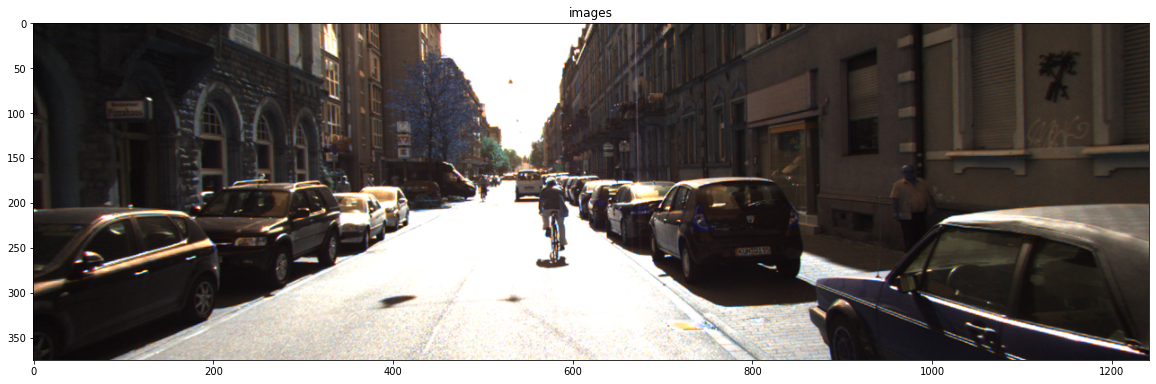

In [6]:
plot_image("images", cv2.imread(os.path.join(IMAGE_DIR, img_pairs[0][0])))

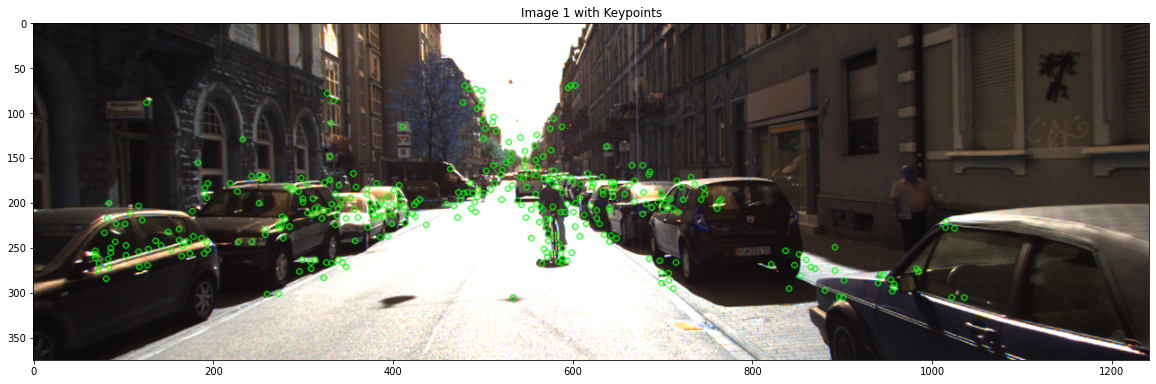

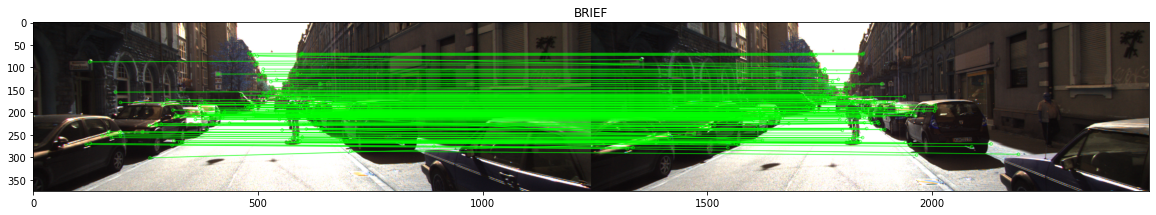

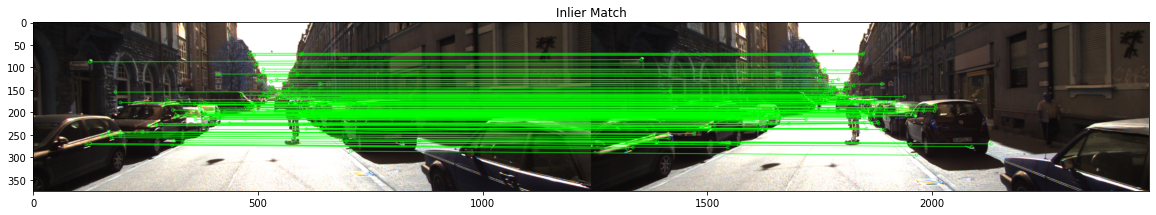

Rotation:
[[ 9.99952479e-01 -9.51135372e-04  9.70237505e-03]
 [ 9.49882950e-04  9.99999540e-01  1.33691440e-04]
 [-9.70249775e-03 -1.24468966e-04  9.99952922e-01]]
Translation:
[[-0.06422869]
 [-0.01623204]
 [ 0.99780319]]


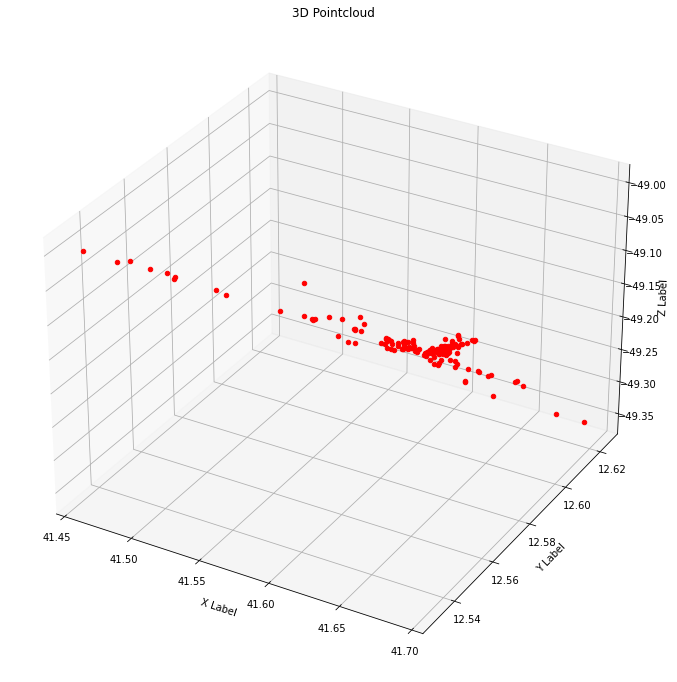

In [7]:
for img1_path, img2_path in img_pairs:
    counter += 1
    img1=cv2.imread(os.path.join(IMAGE_DIR, img1_path))
    img2=cv2.imread(os.path.join(IMAGE_DIR, img2_path))
    
    # Initiate FAST detector
    star = cv2.xfeatures2d.StarDetector_create()
    
    # Initiate BRIEF extractor
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    
    # find the keypoints with STAR
    kp = star.detect(img1,None)
    
    # compute the descriptors with BRIEF
    kp1, des1 = brief.compute(img1, kp)
    img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
    plot_image("Image 1 with Keypoints", img1_kp)

    kp = star.detect(img2,None)
    # compute the descriptors with BRIEF
    kp2, des2 = brief.compute(img2, kp)
    
    #use flann to perform feature matching
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(np.float32(des1),np.float32(des2),k=2) # Use NP.FLOAT32 for ORB, BRIEF, etc

    # store all the good matches as per Lowe's ratio test.
    good_matches = []
    
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    if len(good_matches) > MIN_MATCH_COUNT:
        p1 = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        p2 = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       flags = 2)

    img_briefmatch = cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,**draw_params)
    #cv2.imwrite('sift_match_' + str(counter) + '.png',img_siftmatch)
    plot_image("BRIEF", img_briefmatch)

    #########################
    #2----essential matrix--#
    #########################
    E, mask = cv2.findEssentialMat(p1, p2, K, cv2.RANSAC, 0.999, 1.0);

    matchesMask = mask.ravel().tolist()

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)

    img_inliermatch = cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,**draw_params)
    #cv2.imwrite('inlier_match_' + str(counter) + '.png',img_inliermatch)
    plot_image("Inlier Match", img_inliermatch)
    #print("Essential matrix:")
    #print(E)

    ####################
    #3----recoverpose--#
    ####################

    points, R, t, mask = cv2.recoverPose(E, p1, p2)
    print("Rotation:")
    print(R)
    print("Translation:")
    print(t)
    # p1_tmp = np.expand_dims(np.squeeze(p1), 0)
    p1_tmp = np.ones([3, p1.shape[0]])
    p1_tmp[:2,:] = np.squeeze(p1).T
    p2_tmp = np.ones([3, p2.shape[0]])
    p2_tmp[:2,:] = np.squeeze(p2).T
    #print((np.dot(R, p2_tmp) + t) - p1_tmp)

    #######################
    #4----triangulation---#
    #######################

    #calculate projection matrix for both camera
    M_r = np.hstack((R, t))
    M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))

    P_l = np.dot(K,  M_l)
    P_r = np.dot(K,  M_r)

    # undistort points
    p1 = p1[np.asarray(matchesMask)==1,:,:]
    p2 = p2[np.asarray(matchesMask)==1,:,:]
    p1_un = cv2.undistortPoints(p1,K,None)
    p2_un = cv2.undistortPoints(p2,K,None)
    p1_un = np.squeeze(p1_un)
    p2_un = np.squeeze(p2_un)

    #triangulate points this requires points in normalized coordinate
    point_4d_hom = cv2.triangulatePoints(P_l, P_r, p1_un.T, p2_un.T)
    point_3d = point_4d_hom / np.tile(point_4d_hom[-1, :], (4, 1))
    point_3d = point_3d[:3, :].T

    #############################
    #5----output 3D pointcloud--#
    #############################
    # Display 3D points
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    for x, y, z in point_3d:
        ax.scatter(x, y, z, c="r", marker="o")
        
    plt.title("3D Pointcloud")
    plt.show()
    fig.savefig(os.path.join(OUTPUT_DIR,'3-D_' + str(counter) + '.jpg'))